# Forest Cover Type Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.linear_model import LogisticRegression

## Load Dataset

In [2]:
data = pd.read_csv("covtype.csv")

# make targets 0-indexed
data['Cover_Type'] -= 1

print(f'Dataset Shape: {data.shape}')
display(data.head())

Dataset Shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,4
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,4
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,1
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,1
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,4


## Analysis of Data

### Data Cleaning

In [3]:
# checking for duplicates and invalid entries
duplicate = data[data.duplicated()]
print("Duplicates:",duplicate.shape[0])

Duplicates: 0


In [4]:
print(data.iloc[:,0:55].isna().sum())

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


## Splitting the data

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,...,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.549798,155.695275,14.107268,269.228935,46.394470,2350.197533,212.133984,223.328595,142.550499,1979.005028,...,0.044108,0.090467,0.077802,0.002767,0.003253,0.000200,0.000486,0.026725,0.023956,0.015094
std,279.837546,111.881499,7.489420,212.300822,58.269175,1559.108759,26.779091,19.770106,38.290110,1323.346698,...,0.205336,0.286850,0.267860,0.052527,0.056942,0.014144,0.022045,0.161279,0.152913,0.121929
min,1859.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2810.000000,58.000000,9.000000,108.000000,7.000000,1104.000000,198.000000,213.000000,119.000000,1022.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2548.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7116.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

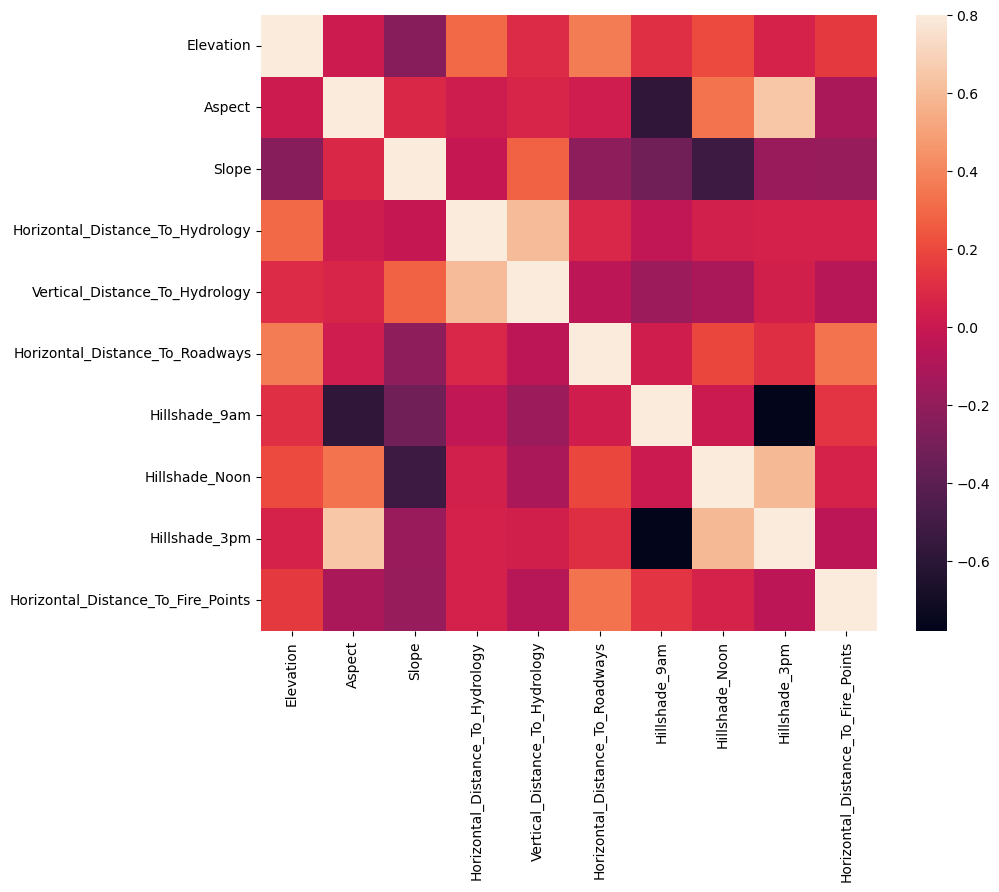

In [5]:
feature_labels = [l for l in data.columns if l != 'Cover_Type']
numerical_labels = [l for l in data.columns if 'Wilderness_Area' not in l and not 'Soil_Type' in l and l != 'Cover_Type']
categorical_labels = [l for l in data.columns if ('Wilderness_Area' in l or 'Soil_Type' in l) and l != 'Cover_Type']
target_labels = ['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(data[feature_labels], data[target_labels], test_size=0.20, stratify=data[target_labels])
print(X_train.columns)
   
display(X_train.describe())
size = 10
corrmatrix = X_train.iloc[:,:size].corr()
f, ax = plt.subplots(figsize=(10,8))
display(sns.heatmap(corrmatrix,vmax=0.8,square = True))

In [6]:
corrmatrix

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
Elevation,1.000000,0.015353,-0.241518,0.305612,0.092586,0.365057,0.111492,0.204695,0.058706,0.147688
Aspect,0.015353,1.000000,0.079057,0.016627,0.070248,0.025594,-0.579707,0.336421,0.647342,-0.108471
Slope,-0.241518,0.079057,1.000000,-0.009678,0.276404,-0.215861,-0.327171,-0.526364,-0.175391,-0.186416
Horizontal_Distance_To_Hydrology,0.305612,0.016627,-0.009678,1.000000,0.605420,0.072492,-0.027784,0.045470,0.051986,0.052445
Vertical_Distance_To_Hydrology,0.092586,0.070248,0.276404,0.605420,1.000000,-0.046393,-0.166948,-0.112380,0.034390,-0.069207
Horizontal_Distance_To_Roadways,0.365057,0.025594,-0.215861,0.072492,-0.046393,1.000000,0.033797,0.189256,0.106417,0.332177
Hillshade_9am,0.111492,-0.579707,-0.327171,-0.027784,-0.166948,0.033797,1.000000,0.009303,-0.780637,0.132169
Hillshade_Noon,0.204695,0.336421,-0.526364,0.045470,-0.112380,0.189256,0.009303,1.000000,0.594552,0.058469
Hillshade_3pm,0.058706,0.647342,-0.175391,0.051986,0.034390,0.106417,-0.780637,0.594552,1.000000,-0.046874
Horizontal_Distance_To_Fire_Points,0.147688,-0.108471,-0.186416,0.052445,-0.069207,0.332177,0.132169,0.058469,-0.046874,1.000000


In [7]:
high_corr_list = []
for i in range(0, size):
    for j in range(i+1, size):
        if abs(corrmatrix.iloc[i,j])>= 0.5:
            high_corr_list.append([corrmatrix.iloc[i,j],i,j])

# print the higher values
print("Correlation Values:")
cols = data.columns
for v,i,j in sorted(high_corr_list):
    print("\t", cols[i],"and", cols[j],f": {v: .2f}")

Correlation Values:
	 Hillshade_9am and Hillshade_3pm : -0.78
	 Aspect and Hillshade_9am : -0.58
	 Slope and Hillshade_Noon : -0.53
	 Hillshade_Noon and Hillshade_3pm :  0.59
	 Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology :  0.61
	 Aspect and Hillshade_3pm :  0.65


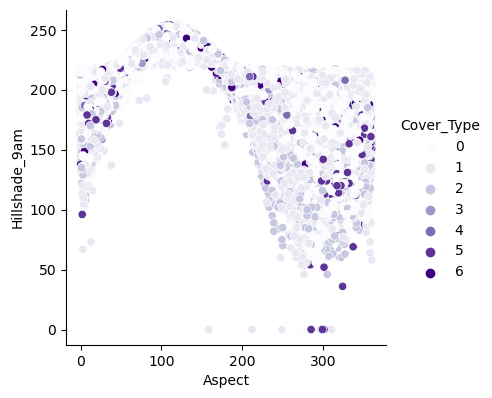

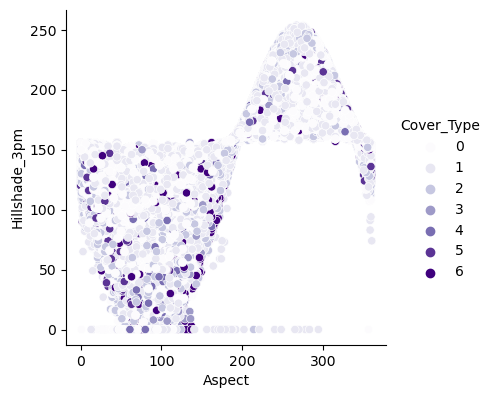

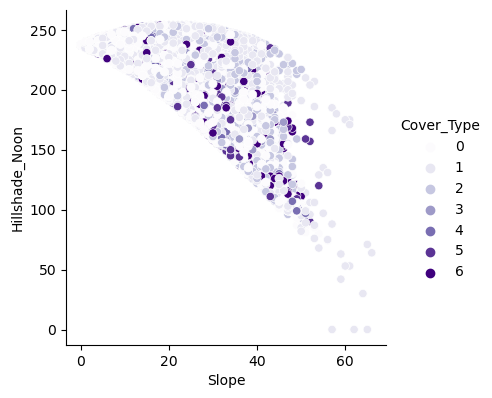

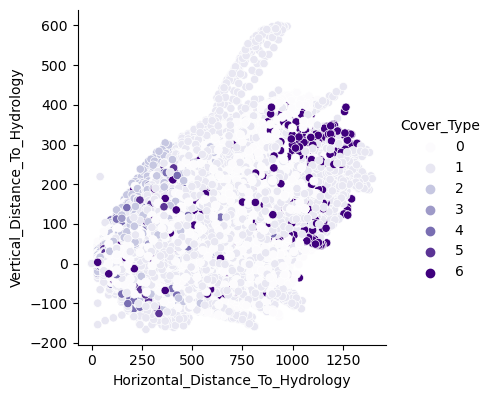

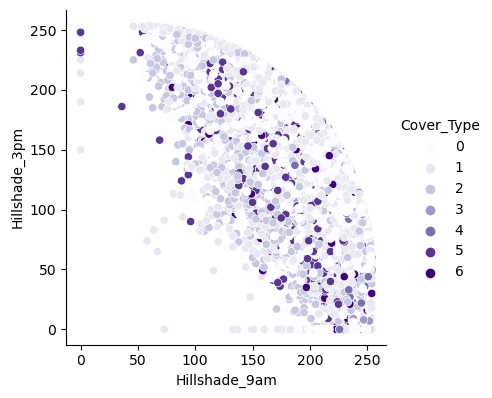

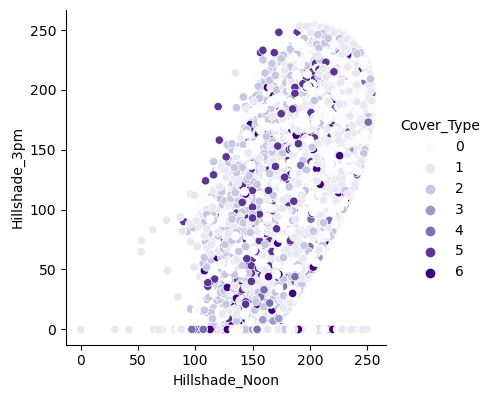

In [8]:
#Plotting a pair plot for the high correlated features
for v,i,j in high_corr_list:
    sns.pairplot(pd.concat([X_train,y_train],axis=1), hue="Cover_Type", height=4, palette = "Purples", x_vars=cols[i],y_vars=cols[j] )
    plt.show()

#### Standardizing the data

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Fitting data using Logistic Regression

In [10]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

C:\Users\chira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\chira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
y_pred = model.predict(X_test_scaled)
#weights_1 = model.coef_

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 72.40%


#### Creating a simple neural network

In [13]:
input_dim = X_train.shape[1]
output_dim = len(np.unique(data[target_labels]))  

model_nm = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(output_dim, activation='softmax')
])

In [14]:
# optimizer = Adam(lr=0.001)
# loss = SparseCategoricalCrossentropy()

# model_nm.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [15]:
# epochs = 30
# batch_size = 32

# history = model_nm.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)


In [16]:
y_pred_nm = model_nm.predict(X_test)

3632/3632 [==============================] - 3s 663us/step


In [17]:
test_loss, test_accuracy = model_nm.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

#### Apply PCA for a dimentionality reduction

In [ ]:
# # Choose the number of principal components
# n_components = 20

# pca = PCA(n_components=n_components)
# pca.fit(X_train_scaled)

# X_train_pca = pca.transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# # Instantiate and train the Logistic Regression model
# clf = LogisticRegression()
# clf.fit(X_train_pca, y_train)

# # Make predictions on the PCA-transformed test data
# y_pred_pca = clf.predict(X_test_pca)

# # Evaluate the accuracy of the model
# accuracy_pca = accuracy_score(y_test, y_pred_pca)
# print(f"Accuracy: {accuracy_pca * 100:.2f}%")

In [18]:
n_components = np.arange(2, X_train.shape[1] + 1, 10)
explained_variance_ratios = []

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    clf = LogisticRegression()
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    print('For component size: ',n ,' Accuracy: ', accuracy_pca)
    explained_variance_ratios.append(accuracy_pca)


C:\Users\chira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For component size:  2  Accuracy:  0.5389103551543419


C:\Users\chira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\chira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For component size:  12  Accuracy:  0.6831837388019242


C:\Users\chira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\chira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For component size:  22  Accuracy:  0.6905071297642918


C:\Users\chira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\chira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For component size:  32  Accuracy:  0.6988718019328245


C:\Users\chira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\chira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For component size:  42  Accuracy:  0.714731977659785


C:\Users\chira\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For component size:  52  Accuracy:  0.7240174522172406


C:\Users\chira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


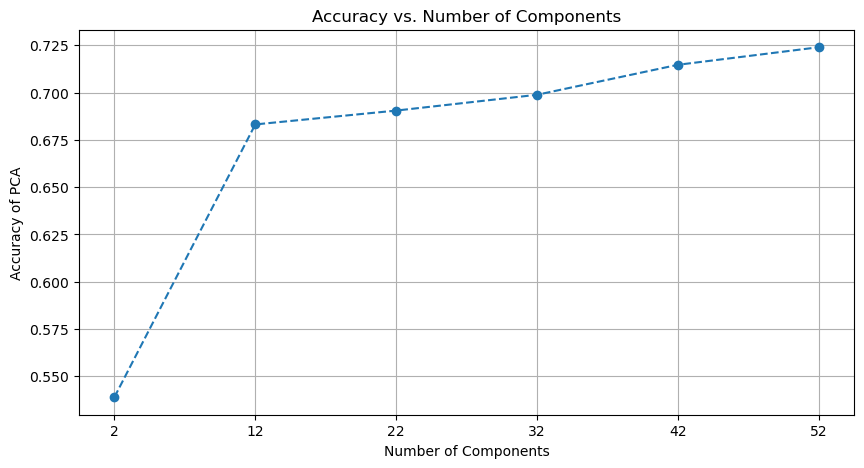

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(n_components, explained_variance_ratios, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy of PCA')
plt.title('Accuracy vs. Number of Components')
plt.xticks(n_components)
plt.grid()
plt.show()


In [ ]:
# from sklearn.datasets import make_classification
# # Choose a fraction of features to be altered (e.g., 50%)
# column_index = 1

# X_train[:, column_index] = X_train[:, column_index] * 2

In [20]:
base_estimator = DecisionTreeClassifier()
bagging_clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)
bagging_clf.fit(X_train, y_train)


C:\Users\chira\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=42)

In [ ]:
# y_pred_bagging_train_wrong = bagging_clf.predict(X_train)
# accuracy_train_bagging = accuracy_score(y_train, y_pred_bagging_train_wrong)
# print(f"Accuracy: {accuracy_train_bagging:.2f}")


In [ ]:
# base_estimator = DecisionTreeClassifier()
# bagging_clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)
# bagging_clf.fit(X_train, y_train)

In [21]:
y_pred_bagging = bagging_clf.predict(X_test)

# Calculate accuracy
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f"Accuracy: {accuracy_bagging * 100:.2f}%")


Accuracy: 96.78%


In [ ]:
y_pred_nm = y_pred_nm.flatten()

In [ ]:
# Confusion matrix
print(f"Accuracy after Logistic Regression: {accuracy * 100:.2f}%")
print(confusion_matrix(y_test, y_pred))
print('****')

print(f"Accuracy after dimentional reduction was implemented using PCA: {accuracy_pca * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_pca))
print('****')

print(f"Accuracy after bagging: {accuracy_bagging * 100:.2f}%")
print(confusion_matrix(y_test, y_pred_bagging))
print('****')

#print(f"Accuracy after Neural Network implementation: {test_accuracy * 100:.2f}%")
#print(confusion_matrix(y_test, y_pred_nm))

In [22]:
print(f"Test data accuracy after bagging: {accuracy_bagging * 100:.2f}%")
print(('Confusion Matrix: '))
print(confusion_matrix(y_test, y_pred_bagging))

Test data accuracy after bagging: 96.78%
Confusion Matrix: 
[[40853  1409     0     0    19     3    84]
 [ 1016 55426    77     0    76    52    14]
 [    1    73  6922    33    10   112     0]
 [    0     0    50   487     0    12     0]
 [   19   219    15     0  1642     4     0]
 [    5    59   163    17     9  3220     0]
 [  171    19     0     0     1     0  3911]]


In [ ]:
print(f"Accuracy after Logistic Regression: {accuracy * 100:.2f}%")
print(f"Accuracy after Neural Network implementation: {test_accuracy * 100:.2f}%")
print(f"Accuracy after dimentional reduction was implemented using PCA: {accuracy_pca * 100:.2f}%")
print(f"Accuracy after bagging: {accuracy_bagging * 100:.2f}%")

In [ ]:
output_dim

In [ ]:
print(data.columns)

In [23]:
y_pred_train = model.predict(X_train_scaled)

accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy: {accuracy_train * 100:.2f}%")

Accuracy: 72.42%


In [ ]:
y_pred_pca_train = clf.predict(X_train_pca)

# Evaluate the accuracy of the model
accuracy_pca_train = accuracy_score(y_train, y_pred_pca_train)
print(f"Accuracy: {accuracy_pca_train * 100:.2f}%")

In [28]:
y_pred_bagging_train = bagging_clf.predict(X_train)

# Calculate accuracy
accuracy_bagging_train = accuracy_score(y_train, y_pred_bagging_train)
print(f"Bagging accuracy after introducing innacuracy in training data: {accuracy_bagging_train * 100}%")
print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred_bagging_train))

Bagging accuracy after introducing innacuracy in training data: 99.99956971573269%
Confusion matrix:
[[169471      1      0      0      0      0      0]
 [     1 226639      0      0      0      0      0]
 [     0      0  28603      0      0      0      0]
 [     0      0      0   2198      0      0      0]
 [     0      0      0      0   7594      0      0]
 [     0      0      0      0      0  13894      0]
 [     0      0      0      0      0      0  16408]]


In [25]:
y_pred_nm_train = model_nm.predict(X_train)
test_loss_train, test_accuracy_train = model_nm.evaluate(X_train_scaled, y_train)
print(f"Test accuracy: {test_accuracy_train * 100:.2f}%")

14526/14526 [==============================] - 10s 681us/step


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
print(confusion_matrix(y_train, y_pred_bagging_train))

In [ ]:
X_train_pca

In [ ]:
display(X_train.describe())

In [ ]:
y_pred_bagging_train